In [1]:
import os, random
import numpy as np
import torch
import dataset_loader

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os

# Dataset

###### We load the data

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

In [3]:
train_data

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([3, 6, 4, ..., 0, 1, 0], dtype=int64)]

In [4]:
train_images, train_labels = torch.tensor(train_data[0]), torch.tensor(train_data[1])
dev_images, dev_labels = torch.tensor(dev_data[0]), torch.tensor(dev_data[1])
test_images, test_labels = torch.tensor(test_data[0]), torch.tensor(test_data[1])

###### We create datasets and dataloaders

In [5]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, imgs, labels):
        'Initialization'
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return self.imgs.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.imgs[index]
        y = self.labels[index]

        return X, y

In [6]:
#prepare train dataloader
batch_size = 128

dl = Dataset(train_images, train_labels)
train_loader = torch.utils.data.DataLoader(dl, batch_size=batch_size,shuffle=True)
test = next(iter(train_loader))
print(f"X_component: {test[0].shape}, y_component: {test[1].shape}")

X_component: torch.Size([128, 784]), y_component: torch.Size([128])


In [7]:
#prepare developpement dataloader
batch_size = 128

dl = Dataset(dev_images, dev_labels)
dev_loader = torch.utils.data.DataLoader(dl, batch_size=batch_size,shuffle=True)
test = next(iter(dev_loader))
print(f"X_component: {test[0].shape}, y_component: {test[1].shape}")

X_component: torch.Size([128, 784]), y_component: torch.Size([128])


# Models

###### First Architecture we use

In [8]:
class VAEEncoder(nn.Module):
    def __init__(self, dim_input, dim_latent):
        super().__init__()
        
        self.lin1 = nn.Linear(dim_input, 64)
        self.mu_proj = nn.Linear(64,dim_latent)
        self.logsigma_proj = nn.Linear(64,dim_latent)
        

    def forward(self, inputs):
        out = torch.relu(self.lin1(inputs))
        mu = self.mu_proj(out)
        log_sigma_squared = self.logsigma_proj(out)
        return mu, log_sigma_squared

In [9]:
class VAEDecoder(nn.Module):
    def __init__(self, dim_latent, dim_output = 28*28):
        super().__init__()
        
        self.lin1 = nn.Linear(dim_latent, 64)
        self.proj_mu = nn.Linear(64,dim_output)
        

    def forward(self, inputs):
        out = torch.relu(self.lin1(inputs))
        mu = self.proj_mu(out)
        sigma = torch.ones_like(mu)*0.01
        
        #sigmoid a test
        return mu, sigma

###### Second Architecture we use with more hidden layers

In [10]:
class VAEEncoder(nn.Module):
    def __init__(self, dim_input, dim_latent):
        super().__init__()
        
        self.lin1 = nn.Linear(dim_input, 256)
        self.mu_proj = nn.Linear(64,dim_latent)
        self.logsigma_proj = nn.Linear(64,dim_latent)
        
        self.lin2 = nn.Linear(256, 128)
        self.lin3 = nn.Linear(128, 64)

    def forward(self, inputs):
        out = torch.tanh(self.lin1(inputs))
        out = torch.tanh(self.lin2(out))
        out = torch.tanh(self.lin3(out))
        
        mu = self.mu_proj(out)
        log_sigma_squared = self.logsigma_proj(out)
        return mu, log_sigma_squared

In [11]:
class VAEDecoder(nn.Module):
    def __init__(self, dim_latent, dim_output = 28*28):
        super().__init__()
        
        self.lin1 = nn.Linear(dim_latent, 64)
        self.proj_mu = nn.Linear(256,dim_output)
        
        self.lin2 = nn.Linear(64, 128)
        self.lin3 = nn.Linear(128, 256)

    def forward(self, inputs):
        out = torch.tanh(self.lin1(inputs))
        out = torch.tanh(self.lin2(out))
        out = torch.tanh(self.lin3(out))
        mu = self.proj_mu(out)
        sigma = torch.ones_like(mu)*0.01
        
        #sigmoid a test
        return torch.clamp(mu,0,1), sigma

###### We try the architecture before training to check everything work well

In [12]:
dim_latent = 2

encoder = VAEEncoder(784,dim_latent)
mu, log_sigma_squared = encoder(test[0])

print(f"mus shape: {mu.shape}, logsigmas shape: {log_sigma_squared.shape}")

e = torch.normal(0, 1., mu.shape)
z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))

print(f"Latent space shape: {z.shape}")

decoder = VAEDecoder(dim_latent)
out_mu, out_sigma = decoder(z)

print(f"out_mu shape: {out_mu.shape}, out_sigma shape: {out_sigma.shape}")

mus shape: torch.Size([128, 2]), logsigmas shape: torch.Size([128, 2])
Latent space shape: torch.Size([128, 2])
out_mu shape: torch.Size([128, 784]), out_sigma shape: torch.Size([128, 784])


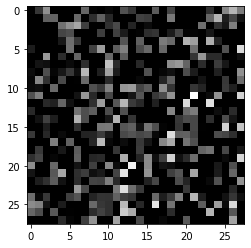

In [13]:
plt.imshow(out_mu[0].detach().numpy().reshape(28,28), cmap = 'gray')

# Loss function


In [14]:
encoder.parameters()

<generator object Module.parameters at 0x000001793939DA50>

In [16]:
class Trainer:
    '''This class is used to train the models and displays information during the training so that we can monitoring it'''
    def __init__(self, encoder, decoder, optimizer, device, train_loader, valid_loader = None, epochs = 10, save = False):
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.epochs = epochs
        self.save = save
        self.history = {'train_loss_rec' : [], 'train_loss_kld' : [], 'train_loss' : [], 
                        'dev_loss_rec' : [], 'dev_loss_kld' : [], 'dev_loss' : []}
    
    def valid_epoch(self):
        '''One epoch on validation'''
        
        #one epoch = one batch this way we add randomness
        batch = next(iter(self.valid_loader))[0].to(self.device)
        mu, log_sigma_squared = self.encoder(batch)
        
        e = torch.normal(0, 1., mu.shape).to(self.device)
        z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))

        out_mu, out_sigma = self.decoder(z)

        lossReconc = torch.mean(torch.sum((batch - out_mu )**2, axis = 1))

        LossKLD = torch.mean(-0.5 *torch.sum(1 + log_sigma_squared - mu.pow(2) - log_sigma_squared.exp(), axis = 1))
        
        loss = lossReconc + LossKLD
        
        self.history['dev_loss_rec'].append(lossReconc.detach().cpu().item())
        self.history['dev_loss_kld'].append(LossKLD.detach().cpu().item())
        self.history['dev_loss'].append(loss.detach().cpu().item())
        
        return batch, out_mu, e
        
                

    def train_epoch(self):
        '''One epoch on train'''
        
        #one epoch = one batch this way we add randomness
        batch = next(iter(self.train_loader))[0].to(self.device) 
        mu, log_sigma_squared = self.encoder(batch)
        
        e = torch.normal(0, 1., mu.shape).to(self.device)
        z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))

        out_mu, out_sigma = self.decoder(z)

        lossReconc = torch.mean(torch.sum((batch - out_mu )**2, axis = 1))

        LossKLD = torch.mean(-0.5 *torch.sum(1 + log_sigma_squared - mu.pow(2) - log_sigma_squared.exp(), axis = 1))
        
        loss = lossReconc + LossKLD
        
        self.history['train_loss_rec'].append(lossReconc.detach().cpu().item())
        self.history['train_loss_kld'].append(LossKLD.detach().cpu().item())
        self.history['train_loss'].append(loss.detach().cpu().item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return batch, out_mu, e
        

    def display_losses(self, batch, out_mu, e):
        
        #look if we have a dev set
        set_name = ['train']
        if self.valid_loader:
            set_name.append('dev')
        
        #plot the losses
        for i in range(len(set_name)):
            fig,ax = plt.subplots(1,3, figsize = (10,2))
            s = set_name[i]
            arange = np.arange(len(self.history[s + '_loss_rec']))
            ax[0].plot(arange, self.history[s + '_loss_rec'])
            ax[1].plot(arange, self.history[s + '_loss_kld'])
            ax[2].plot(arange, self.history[s + '_loss'])
            ax[0].set_title(f"Reconstruction Loss ({s})")
            ax[1].set_title(f"KLD Loss ({s})")
            ax[2].set_title(f"Global Loss ({s})")
        
        #plots images of reconstruction and generation
        imgs = batch.detach().cpu()
        rec_imgs = out_mu.detach().cpu()
        gen_imgs = self.decoder(e)[0].detach().cpu()
        nb = 32
        axes=[]
        fig=plt.figure(figsize = (10,5))
        pic = []
        for i in range(4):
            for j in range(2):#affichage des reconstructions
                pic.append(imgs[i*2 + j])
                pic.append(rec_imgs[i*2 + j])
            for j in range(4): #affiche d'images générées à partir d'espace latent gaussien centré réduit
                pic.append(gen_imgs[i*4 + j])
        for a in range(nb):
            b = pic[a].view(28,28)
            axes.append( fig.add_subplot(4, 8, a+1) )
            plt.imshow(b, cmap = 'gray')
            plt.axis('off')
        fig.tight_layout()
        
        plt.show()
        
        #print the last loss because value can be hard to read on the graph
        for s in set_name: 
            ep = len(self.history[s + '_loss_rec'])
            rec = self.history[s + '_loss_rec'][-1]
            kld = self.history[s + '_loss_kld'][-1]
            
            print(f"({s}) epoch {ep}:    loss: {rec+kld}        lossRec: {rec}         lossKLD: {kld}")
        clear_output(wait=True)
        
    def save_model(self):
        PATH = "encoder.pth"
        torch.save({
            'epoch': self.epochs,
            'net_state_dict': self.encoder.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'rng_state': torch.get_rng_state()
        }, PATH)

        PATH = "decoder.pth"
        torch.save({
            'epoch': self.epochs,
            'net_state_dict': self.decoder.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'rng_state': torch.get_rng_state()
        }, PATH)
        
        
    def train(self):
        #iterate over the epochs
        for epoch in range(self.epochs):
            batch, out_mu, e = self.train_epoch()

            if self.valid_loader:
                batch, out_mu, e  = self.valid_epoch()
            
            if epoch%2001 == 2000: #print only all 2000th epochs
                self.display_losses(batch, out_mu, e)
            
        if self.save:
            self.save_model()

        return self.history

In [17]:
def load_model(device):
    PATH_ENC = "encoder.pth"
    PATH_DEC = "decoder.pth"
    cpenc = torch.load(PATH_ENC)
    cpdec = torch.load(PATH_DEC)
    encoder.load_state_dict(cpenc['net_state_dict'])
    decoder.load_state_dict(cpdec['net_state_dict'])

    iter_base = cpenc['epoch']
    return encoder.to(device), decoder.to(device), iter_base

###### Let's train our model

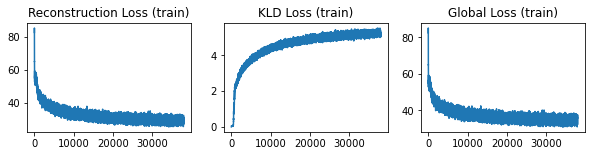

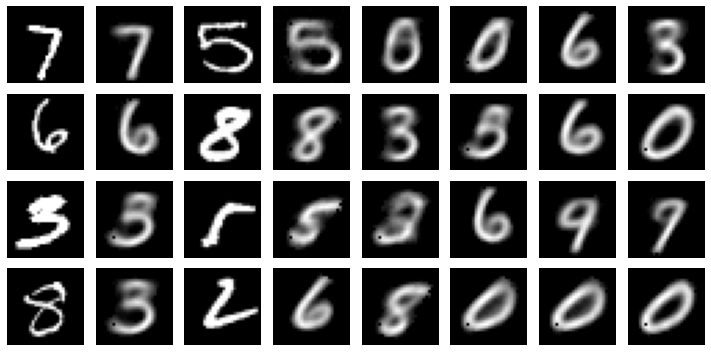

(train) epoch 38019:    loss: 37.46619892120361        lossRec: 32.39150619506836         lossKLD: 5.074692726135254


In [20]:
resume_train = False #If True then we will load an alreay trained model if it exist else we will directly train one

epoch = 40001
dim_latent = 2
image_size= 784
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

    
if resume_train and os.path.isfile("encoder.pth") and os.path.isfile("decoder.pth"):
    
    encoder, decoder, ite = load_model(device)
    
else:
    encoder = VAEEncoder(image_size,dim_latent).to(device)
    decoder = VAEDecoder(dim_latent).to(device)

    params = list(encoder.parameters())  + list(decoder.parameters())

    optimizer = torch.optim.SGD(params , lr=0.0005, momentum=0.9)

    trainer = Trainer(encoder, decoder, optimizer, device, train_loader, valid_loader = None, epochs = epoch, save = True)

    trainer.train()

# Display Latent Space

In [24]:
import matplotlib
from sklearn.decomposition import PCA

C:\Users\Clement\AppData\Local\Temp\ipykernel_22104\908621796.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter)


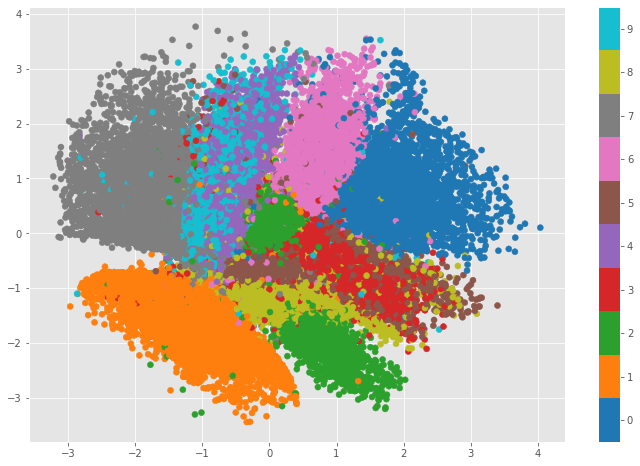

In [25]:
#This cell allow us to print the data of the latent space in 2D

decoder.eval()

points = np.empty((len(train_labels), dim_latent))
with torch.no_grad():
    for i in range(0, len(train_labels), batch_size):
        batch = train_images[i:i+batch_size].to(device)
        mu, _ = encoder(batch)
        points[i:i+batch_size] = mu.detach().cpu().numpy()

        
pca = PCA(n_components=2)
components = pca.fit_transform(points)

import numpy as np
from matplotlib import pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# choose number of classes
n_clusters = 10

clusters = train_labels
### Finally, plot
fig, ax = plt.subplots(figsize=(12,8))

# get discrete colormap
cmap = plt.get_cmap("tab10", n_clusters)

# scatter points
scatter = ax.scatter(components[:,0], components[:, 1], c=clusters, cmap=cmap)

# add colorbar
cbar = plt.colorbar(scatter)

tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)

# set tick labels (as before)
cbar.set_ticklabels(np.arange(n_clusters))

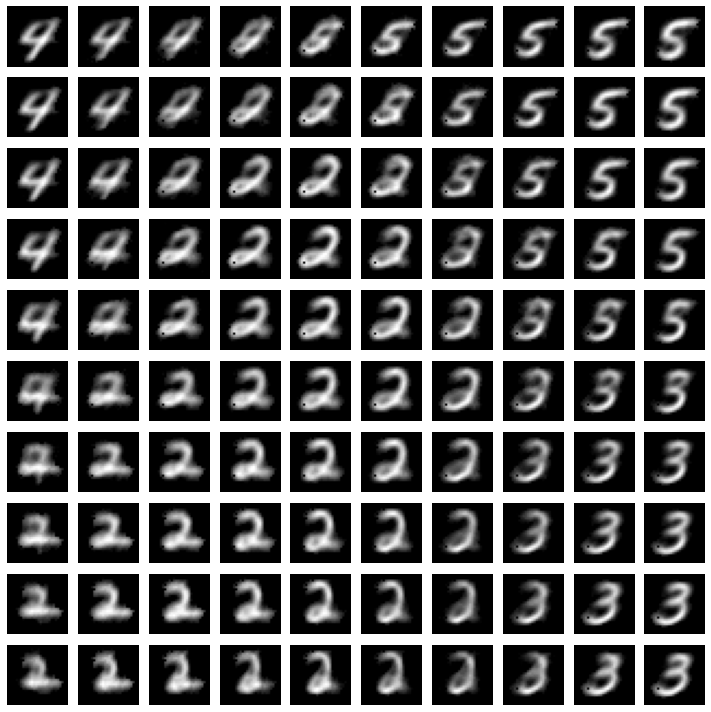

In [26]:
a = torch.linspace(-0.5,0.5,10)
t = torch.zeros((100,2))
for i in range(10):
    for j in range(10):
        t[i*10 + j] = torch.tensor([a[i],a[j]])
        
t = t.to(device)
out = decoder(t)[0]

nb = 100
axes=[]
fig=plt.figure(figsize = (10,10))
pic = []
for i in range(nb):
        pic.append(out[i].detach().cpu())
for a in range(nb):
    b = pic[a].view(28,28)
    axes.append( fig.add_subplot(10, 10, a+1) )
    plt.imshow(b, cmap = 'gray')
    plt.axis('off')
fig.tight_layout()
        
plt.show()